In [1]:
import torch
from torchvision import datasets, transforms

# Define as transformações para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Baixa e carrega o conjunto de treinamento
trainset = datasets.KMNIST('~/.pytorch/KMNIST_data/', download=True, train=True, transform=transform)
#trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# baixa e carrega o conjunto de testes
testset = datasets.KMNIST('~/.pytorch/KMNIST_data/', download=True, train=False, transform=transform)
#testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



38.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

53.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

67.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

87.9%IOPub

Extracting /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw/train-images-idx3-ubyte.gz to /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw



100.7%


Extracting /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw/train-labels-idx1-ubyte.gz to /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw



100.0%


Extracting /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw



100.0%

Extracting /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/joaovkn/.pytorch/KMNIST_data/KMNIST/raw




/home/joaovkn/anaconda3/envs/potato/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Computa a probabilidade das classes (lembrando que usa exp por que a saída da rede é log_softmax)
ps = torch.exp(model(images))
# confirmando se o formato da saída é apropriada, i.e., 64 amostras com probabilidade de pertencer a 10 classes
print(ps.shape)

torch.Size([64, 10])


In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Veja as classes mais prováveis para as 10 primeiras amostras
print(top_class[:10,:])

tensor([[7],
        [5],
        [5],
        [7],
        [2],
        [5],
        [5],
        [5],
        [2],
        [5]])


In [5]:
equals = top_class == labels.view(*top_class.shape)
# * quer dizer que está desempacotando os valores da lista top_class.shape, ou seja, é o mesmo que 
#   fazer labels.view(top_class.shape[0],top_class.shape[1])

print('top_class.shape = ', top_class.shape)
print('*top_class.shape = ', *top_class.shape)
print('equals.shape = ', equals.shape)
#print('equals = ', equals)

top_class.shape =  torch.Size([64, 1])
*top_class.shape =  64 1
equals.shape =  torch.Size([64, 1])


In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Acurácia: {accuracy.item()*100}%')

Acurácia: 6.25%


In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # else pode ser usado em laços tipo for no python, e só será executado se não cair em nenhum break
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # passo de validação
            for images, labels in testloader:
                log_ps = model(images)
                ps = torch.exp(log_ps)
                
                test_loss += criterion(log_ps, labels)  
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.449..  Test Loss: 0.643..  Test Accuracy: 0.813
Epoch: 2/30..  Training Loss: 0.240..  Test Loss: 0.574..  Test Accuracy: 0.833
Epoch: 3/30..  Training Loss: 0.186..  Test Loss: 0.518..  Test Accuracy: 0.855
Epoch: 4/30..  Training Loss: 0.158..  Test Loss: 0.510..  Test Accuracy: 0.861
Epoch: 5/30..  Training Loss: 0.137..  Test Loss: 0.562..  Test Accuracy: 0.852
Epoch: 6/30..  Training Loss: 0.127..  Test Loss: 0.553..  Test Accuracy: 0.868
Epoch: 7/30..  Training Loss: 0.116..  Test Loss: 0.478..  Test Accuracy: 0.880
Epoch: 8/30..  Training Loss: 0.107..  Test Loss: 0.480..  Test Accuracy: 0.883
Epoch: 9/30..  Training Loss: 0.102..  Test Loss: 0.553..  Test Accuracy: 0.873
Epoch: 10/30..  Training Loss: 0.092..  Test Loss: 0.507..  Test Accuracy: 0.884
Epoch: 11/30..  Training Loss: 0.093..  Test Loss: 0.531..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.090..  Test Loss: 0.515..  Test Accuracy: 0.881
Epoch: 13/30..  Training Loss: 0.077.

In [8]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x))
        
        return x

In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for image, label in trainloader:
        optimizer.zero_grad()
        log_ps = model(image)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for image, label in testloader:         
                
                log_ps = model.forward(image)
                prob = torch.exp(log_ps)
                
                test_loss+= criterion(log_ps, label)
                
                
                k_prob, k_class = prob.topk(1, dim=1)
                equals = k_class == label.view(*k_class.shape)
                
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

/tmp/ipykernel_16708/2178546981.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc4(x))


Epoch: 1/30..  Training Loss: 0.614..  Test Loss: 0.764..  Test Accuracy: 0.772
Epoch: 2/30..  Training Loss: 0.394..  Test Loss: 0.599..  Test Accuracy: 0.813
Epoch: 3/30..  Training Loss: 0.345..  Test Loss: 0.526..  Test Accuracy: 0.845
Epoch: 4/30..  Training Loss: 0.314..  Test Loss: 0.583..  Test Accuracy: 0.834
Epoch: 5/30..  Training Loss: 0.289..  Test Loss: 0.533..  Test Accuracy: 0.847
Epoch: 6/30..  Training Loss: 0.282..  Test Loss: 0.476..  Test Accuracy: 0.863
Epoch: 7/30..  Training Loss: 0.268..  Test Loss: 0.455..  Test Accuracy: 0.869
Epoch: 8/30..  Training Loss: 0.253..  Test Loss: 0.531..  Test Accuracy: 0.851
Epoch: 9/30..  Training Loss: 0.254..  Test Loss: 0.487..  Test Accuracy: 0.876
Epoch: 10/30..  Training Loss: 0.243..  Test Loss: 0.484..  Test Accuracy: 0.871
Epoch: 11/30..  Training Loss: 0.232..  Test Loss: 0.473..  Test Accuracy: 0.878
Epoch: 12/30..  Training Loss: 0.223..  Test Loss: 0.474..  Test Accuracy: 0.874
Epoch: 13/30..  Training Loss: 0.224.

/tmp/ipykernel_16708/2178546981.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc4(x))


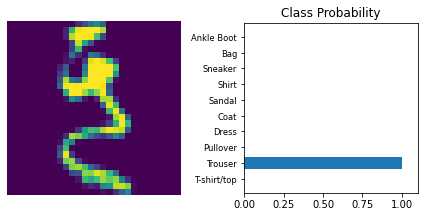

In [11]:
# Importando o módulo helper para ajudar a plotar
import helper

# Testando nossa rede

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convertendo imagens 2D em tensores 1D
img = img.view(1, 784)

# Computando o log das probabilidades para cada imagem (com log_softmax)
with torch.no_grad():
    output = model.forward(img)

# computa as probabilidades fazendo o exponencial do log das probabilidades 
ps = torch.exp(output)

# plotando as probabilidades
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [16]:
# Define a transformação para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# download e carrega os dados de treinamento
trainset = datasets.KMNIST('~/.pytorch/KMNIST_data/', download=True, train=True, transform=transform)
#trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# baixa e carrega o conjunto de testes
testset = datasets.KMNIST('~/.pytorch/KMNIST_data/', download=True, train=False, transform=transform)
#testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # download e carrega os dados de validação/teste
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

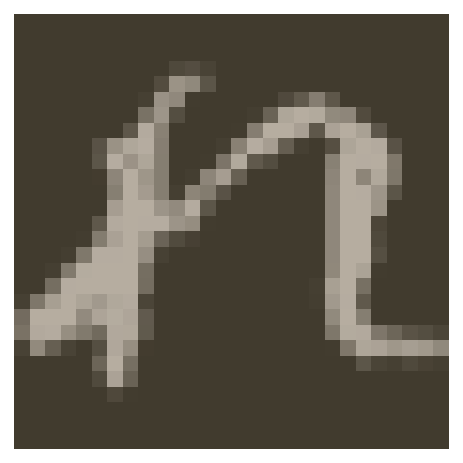

In [17]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In [18]:
# Criando a rede, definindo o criterion (função loss) e o otimizador
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 2.073..  Test Loss: 1.803..  Test Accuracy: 0.400
Epoch: 1/2..  Training Loss: 1.410..  Test Loss: 1.471..  Test Accuracy: 0.525
Epoch: 1/2..  Training Loss: 1.101..  Test Loss: 1.292..  Test Accuracy: 0.588
Epoch: 1/2..  Training Loss: 0.941..  Test Loss: 1.139..  Test Accuracy: 0.636
Epoch: 1/2..  Training Loss: 0.917..  Test Loss: 1.061..  Test Accuracy: 0.663
Epoch: 1/2..  Training Loss: 0.814..  Test Loss: 1.033..  Test Accuracy: 0.667
Epoch: 1/2..  Training Loss: 0.749..  Test Loss: 0.980..  Test Accuracy: 0.686
Epoch: 1/2..  Training Loss: 0.760..  Test Loss: 0.965..  Test Accuracy: 0.685
Epoch: 1/2..  Training Loss: 0.658..  Test Loss: 0.894..  Test Accuracy: 0.713
Epoch: 1/2..  Training Loss: 0.681..  Test Loss: 0.872..  Test Accuracy: 0.722
Epoch: 1/2..  Training Loss: 0.694..  Test Loss: 0.851..  Test Accuracy: 0.727
Epoch: 1/2..  Training Loss: 0.636..  Test Loss: 0.824..  Test Accuracy: 0.742
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.8

In [20]:
print("Nosso modelo: \n\n", model, '\n')
print("As chaves do dicionário: \n\n", model.state_dict().keys())

Nosso modelo: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

As chaves do dicionário: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [21]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [22]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [23]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
# Testando uma nova rede
model = fc_model.Network(784, 10, [400, 200, 100])
# Vai dar erro porque o número de neurônios nas camadas escondidas são diferentes
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

In [25]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [26]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [27]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Exercício em grupo ##
Cada grupo deve desenvolver uma rede neural MLP para classificar o dataset Kuzushiji-MNIST. O objetivo é conseguir a melhor acurácia no conjunto de teste.

Sugestões:

Testar diferentes configurações, como número de camadas escondidas e neurônios por camadas;
Testar como funciona com ou sem dropout;
Testar diferentes otimizadores (não apenas SGD) e diferentes valores de taxa de aprendizado;
Testar possiveis transformações no dataset;
Testar diferente números de épocas.
Apresentação:

Carregar o modelo treinado e executar o passo de inferência sobre o conjunto de testes;
Mostrar gráfico de convergência durante as épocas, considerando o conjunto de treinamento e o conjunto de testes;
Mostrar matriz de confusão, acurácia, e demais métricas que acharem necessárias.

In [42]:
# Criando a rede, definindo o criterion (função loss) e o otimizador
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
lrate= lr=0.001
# optimizer = optim.Adam(model.parameters(), lr=lrate)
# optimizer = optim.Adamax(model.parameters(), lr=lrate)
optimizer = optim.ASGD(model.parameters(), lr=lrate)

In [43]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=30)

Epoch: 1/30..  Training Loss: 2.305..  Test Loss: 2.303..  Test Accuracy: 0.108
Epoch: 1/30..  Training Loss: 2.306..  Test Loss: 2.302..  Test Accuracy: 0.113
Epoch: 1/30..  Training Loss: 2.307..  Test Loss: 2.301..  Test Accuracy: 0.114
Epoch: 1/30..  Training Loss: 2.306..  Test Loss: 2.301..  Test Accuracy: 0.119
Epoch: 1/30..  Training Loss: 2.304..  Test Loss: 2.300..  Test Accuracy: 0.122
Epoch: 1/30..  Training Loss: 2.305..  Test Loss: 2.300..  Test Accuracy: 0.128
Epoch: 1/30..  Training Loss: 2.302..  Test Loss: 2.299..  Test Accuracy: 0.129
Epoch: 1/30..  Training Loss: 2.301..  Test Loss: 2.299..  Test Accuracy: 0.136
Epoch: 1/30..  Training Loss: 2.303..  Test Loss: 2.298..  Test Accuracy: 0.139
Epoch: 1/30..  Training Loss: 2.300..  Test Loss: 2.298..  Test Accuracy: 0.145
Epoch: 1/30..  Training Loss: 2.297..  Test Loss: 2.297..  Test Accuracy: 0.151
Epoch: 1/30..  Training Loss: 2.302..  Test Loss: 2.297..  Test Accuracy: 0.152
Epoch: 1/30..  Training Loss: 2.303..  T

Epoch: 5/30..  Training Loss: 2.142..  Test Loss: 2.146..  Test Accuracy: 0.338
Epoch: 5/30..  Training Loss: 2.134..  Test Loss: 2.142..  Test Accuracy: 0.337
Epoch: 5/30..  Training Loss: 2.126..  Test Loss: 2.138..  Test Accuracy: 0.337
Epoch: 5/30..  Training Loss: 2.124..  Test Loss: 2.133..  Test Accuracy: 0.338
Epoch: 5/30..  Training Loss: 2.117..  Test Loss: 2.129..  Test Accuracy: 0.339
Epoch: 5/30..  Training Loss: 2.116..  Test Loss: 2.124..  Test Accuracy: 0.346
Epoch: 5/30..  Training Loss: 2.118..  Test Loss: 2.120..  Test Accuracy: 0.351
Epoch: 5/30..  Training Loss: 2.112..  Test Loss: 2.116..  Test Accuracy: 0.351
Epoch: 5/30..  Training Loss: 2.105..  Test Loss: 2.111..  Test Accuracy: 0.356
Epoch: 5/30..  Training Loss: 2.091..  Test Loss: 2.107..  Test Accuracy: 0.356
Epoch: 5/30..  Training Loss: 2.073..  Test Loss: 2.101..  Test Accuracy: 0.356
Epoch: 5/30..  Training Loss: 2.076..  Test Loss: 2.096..  Test Accuracy: 0.356
Epoch: 5/30..  Training Loss: 2.078..  T

Epoch: 9/30..  Training Loss: 1.615..  Test Loss: 1.725..  Test Accuracy: 0.460
Epoch: 9/30..  Training Loss: 1.578..  Test Loss: 1.724..  Test Accuracy: 0.459
Epoch: 9/30..  Training Loss: 1.548..  Test Loss: 1.724..  Test Accuracy: 0.462
Epoch: 9/30..  Training Loss: 1.582..  Test Loss: 1.716..  Test Accuracy: 0.462
Epoch: 9/30..  Training Loss: 1.573..  Test Loss: 1.709..  Test Accuracy: 0.465
Epoch: 10/30..  Training Loss: 1.574..  Test Loss: 1.704..  Test Accuracy: 0.465
Epoch: 10/30..  Training Loss: 1.557..  Test Loss: 1.700..  Test Accuracy: 0.466
Epoch: 10/30..  Training Loss: 1.566..  Test Loss: 1.702..  Test Accuracy: 0.462
Epoch: 10/30..  Training Loss: 1.578..  Test Loss: 1.697..  Test Accuracy: 0.463
Epoch: 10/30..  Training Loss: 1.545..  Test Loss: 1.696..  Test Accuracy: 0.464
Epoch: 10/30..  Training Loss: 1.532..  Test Loss: 1.690..  Test Accuracy: 0.463
Epoch: 10/30..  Training Loss: 1.567..  Test Loss: 1.688..  Test Accuracy: 0.463
Epoch: 10/30..  Training Loss: 1.

Epoch: 14/30..  Training Loss: 1.220..  Test Loss: 1.437..  Test Accuracy: 0.555
Epoch: 14/30..  Training Loss: 1.228..  Test Loss: 1.433..  Test Accuracy: 0.556
Epoch: 14/30..  Training Loss: 1.206..  Test Loss: 1.428..  Test Accuracy: 0.557
Epoch: 14/30..  Training Loss: 1.233..  Test Loss: 1.429..  Test Accuracy: 0.557
Epoch: 14/30..  Training Loss: 1.239..  Test Loss: 1.426..  Test Accuracy: 0.560
Epoch: 14/30..  Training Loss: 1.244..  Test Loss: 1.426..  Test Accuracy: 0.559
Epoch: 14/30..  Training Loss: 1.233..  Test Loss: 1.424..  Test Accuracy: 0.561
Epoch: 14/30..  Training Loss: 1.217..  Test Loss: 1.426..  Test Accuracy: 0.557
Epoch: 14/30..  Training Loss: 1.202..  Test Loss: 1.424..  Test Accuracy: 0.558
Epoch: 14/30..  Training Loss: 1.231..  Test Loss: 1.426..  Test Accuracy: 0.559
Epoch: 14/30..  Training Loss: 1.212..  Test Loss: 1.415..  Test Accuracy: 0.563
Epoch: 14/30..  Training Loss: 1.232..  Test Loss: 1.414..  Test Accuracy: 0.563
Epoch: 14/30..  Training Los

Epoch: 18/30..  Training Loss: 1.019..  Test Loss: 1.267..  Test Accuracy: 0.609
Epoch: 18/30..  Training Loss: 1.058..  Test Loss: 1.267..  Test Accuracy: 0.608
Epoch: 18/30..  Training Loss: 1.048..  Test Loss: 1.269..  Test Accuracy: 0.606
Epoch: 18/30..  Training Loss: 1.026..  Test Loss: 1.269..  Test Accuracy: 0.607
Epoch: 18/30..  Training Loss: 1.072..  Test Loss: 1.263..  Test Accuracy: 0.610
Epoch: 18/30..  Training Loss: 1.057..  Test Loss: 1.267..  Test Accuracy: 0.606
Epoch: 18/30..  Training Loss: 1.044..  Test Loss: 1.261..  Test Accuracy: 0.608
Epoch: 18/30..  Training Loss: 0.997..  Test Loss: 1.260..  Test Accuracy: 0.609
Epoch: 18/30..  Training Loss: 1.023..  Test Loss: 1.263..  Test Accuracy: 0.608
Epoch: 18/30..  Training Loss: 1.036..  Test Loss: 1.261..  Test Accuracy: 0.608
Epoch: 18/30..  Training Loss: 1.012..  Test Loss: 1.255..  Test Accuracy: 0.610
Epoch: 18/30..  Training Loss: 0.978..  Test Loss: 1.256..  Test Accuracy: 0.609
Epoch: 19/30..  Training Los

Epoch: 22/30..  Training Loss: 0.914..  Test Loss: 1.160..  Test Accuracy: 0.633
Epoch: 22/30..  Training Loss: 0.895..  Test Loss: 1.159..  Test Accuracy: 0.633
Epoch: 22/30..  Training Loss: 0.903..  Test Loss: 1.159..  Test Accuracy: 0.634
Epoch: 23/30..  Training Loss: 0.943..  Test Loss: 1.156..  Test Accuracy: 0.633
Epoch: 23/30..  Training Loss: 0.920..  Test Loss: 1.152..  Test Accuracy: 0.634
Epoch: 23/30..  Training Loss: 0.897..  Test Loss: 1.149..  Test Accuracy: 0.636
Epoch: 23/30..  Training Loss: 0.885..  Test Loss: 1.152..  Test Accuracy: 0.635
Epoch: 23/30..  Training Loss: 0.943..  Test Loss: 1.152..  Test Accuracy: 0.634
Epoch: 23/30..  Training Loss: 0.910..  Test Loss: 1.156..  Test Accuracy: 0.635
Epoch: 23/30..  Training Loss: 0.970..  Test Loss: 1.152..  Test Accuracy: 0.634
Epoch: 23/30..  Training Loss: 0.924..  Test Loss: 1.151..  Test Accuracy: 0.634
Epoch: 23/30..  Training Loss: 0.920..  Test Loss: 1.148..  Test Accuracy: 0.635
Epoch: 23/30..  Training Los

Epoch: 27/30..  Training Loss: 0.826..  Test Loss: 1.072..  Test Accuracy: 0.659
Epoch: 27/30..  Training Loss: 0.811..  Test Loss: 1.074..  Test Accuracy: 0.657
Epoch: 27/30..  Training Loss: 0.838..  Test Loss: 1.075..  Test Accuracy: 0.657
Epoch: 27/30..  Training Loss: 0.819..  Test Loss: 1.074..  Test Accuracy: 0.658
Epoch: 27/30..  Training Loss: 0.800..  Test Loss: 1.073..  Test Accuracy: 0.659
Epoch: 27/30..  Training Loss: 0.819..  Test Loss: 1.073..  Test Accuracy: 0.659
Epoch: 27/30..  Training Loss: 0.843..  Test Loss: 1.073..  Test Accuracy: 0.659
Epoch: 27/30..  Training Loss: 0.846..  Test Loss: 1.071..  Test Accuracy: 0.659
Epoch: 27/30..  Training Loss: 0.830..  Test Loss: 1.074..  Test Accuracy: 0.658
Epoch: 27/30..  Training Loss: 0.797..  Test Loss: 1.072..  Test Accuracy: 0.658
Epoch: 27/30..  Training Loss: 0.819..  Test Loss: 1.069..  Test Accuracy: 0.660
Epoch: 27/30..  Training Loss: 0.808..  Test Loss: 1.064..  Test Accuracy: 0.662
Epoch: 27/30..  Training Los

In [55]:
model = fc_model.Network(784, 49, [529, 361, 128])
criterion = nn.NLLLoss()
lrate= lr=0.002
optimizer = optim.Adam(model.parameters(), lr=lrate)
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=30)

Epoch: 1/30..  Training Loss: 2.286..  Test Loss: 1.721..  Test Accuracy: 0.396
Epoch: 1/30..  Training Loss: 1.344..  Test Loss: 1.341..  Test Accuracy: 0.571
Epoch: 1/30..  Training Loss: 1.074..  Test Loss: 1.204..  Test Accuracy: 0.628
Epoch: 1/30..  Training Loss: 0.983..  Test Loss: 1.209..  Test Accuracy: 0.600
Epoch: 1/30..  Training Loss: 0.881..  Test Loss: 1.065..  Test Accuracy: 0.663
Epoch: 1/30..  Training Loss: 0.895..  Test Loss: 1.006..  Test Accuracy: 0.680
Epoch: 1/30..  Training Loss: 0.812..  Test Loss: 1.008..  Test Accuracy: 0.681
Epoch: 1/30..  Training Loss: 0.781..  Test Loss: 0.932..  Test Accuracy: 0.704
Epoch: 1/30..  Training Loss: 0.788..  Test Loss: 0.946..  Test Accuracy: 0.702
Epoch: 1/30..  Training Loss: 0.709..  Test Loss: 0.949..  Test Accuracy: 0.705
Epoch: 1/30..  Training Loss: 0.758..  Test Loss: 0.880..  Test Accuracy: 0.728
Epoch: 1/30..  Training Loss: 0.712..  Test Loss: 0.829..  Test Accuracy: 0.738
Epoch: 1/30..  Training Loss: 0.699..  T

Epoch: 5/30..  Training Loss: 0.433..  Test Loss: 0.606..  Test Accuracy: 0.819
Epoch: 5/30..  Training Loss: 0.465..  Test Loss: 0.595..  Test Accuracy: 0.819
Epoch: 5/30..  Training Loss: 0.508..  Test Loss: 0.613..  Test Accuracy: 0.824
Epoch: 5/30..  Training Loss: 0.529..  Test Loss: 0.669..  Test Accuracy: 0.809
Epoch: 5/30..  Training Loss: 0.471..  Test Loss: 0.597..  Test Accuracy: 0.823
Epoch: 5/30..  Training Loss: 0.502..  Test Loss: 0.585..  Test Accuracy: 0.832
Epoch: 5/30..  Training Loss: 0.499..  Test Loss: 0.593..  Test Accuracy: 0.824
Epoch: 5/30..  Training Loss: 0.484..  Test Loss: 0.583..  Test Accuracy: 0.828
Epoch: 5/30..  Training Loss: 0.520..  Test Loss: 0.613..  Test Accuracy: 0.818
Epoch: 5/30..  Training Loss: 0.448..  Test Loss: 0.586..  Test Accuracy: 0.825
Epoch: 5/30..  Training Loss: 0.485..  Test Loss: 0.590..  Test Accuracy: 0.824
Epoch: 5/30..  Training Loss: 0.462..  Test Loss: 0.605..  Test Accuracy: 0.818
Epoch: 5/30..  Training Loss: 0.473..  T

Epoch: 9/30..  Training Loss: 0.412..  Test Loss: 0.539..  Test Accuracy: 0.846
Epoch: 9/30..  Training Loss: 0.416..  Test Loss: 0.562..  Test Accuracy: 0.841
Epoch: 9/30..  Training Loss: 0.446..  Test Loss: 0.549..  Test Accuracy: 0.844
Epoch: 9/30..  Training Loss: 0.430..  Test Loss: 0.574..  Test Accuracy: 0.837
Epoch: 9/30..  Training Loss: 0.519..  Test Loss: 0.565..  Test Accuracy: 0.839
Epoch: 10/30..  Training Loss: 0.444..  Test Loss: 0.567..  Test Accuracy: 0.842
Epoch: 10/30..  Training Loss: 0.432..  Test Loss: 0.560..  Test Accuracy: 0.837
Epoch: 10/30..  Training Loss: 0.415..  Test Loss: 0.542..  Test Accuracy: 0.848
Epoch: 10/30..  Training Loss: 0.465..  Test Loss: 0.558..  Test Accuracy: 0.840
Epoch: 10/30..  Training Loss: 0.444..  Test Loss: 0.553..  Test Accuracy: 0.846
Epoch: 10/30..  Training Loss: 0.407..  Test Loss: 0.554..  Test Accuracy: 0.847
Epoch: 10/30..  Training Loss: 0.426..  Test Loss: 0.577..  Test Accuracy: 0.839
Epoch: 10/30..  Training Loss: 0.

Epoch: 14/30..  Training Loss: 0.391..  Test Loss: 0.530..  Test Accuracy: 0.855
Epoch: 14/30..  Training Loss: 0.420..  Test Loss: 0.548..  Test Accuracy: 0.850
Epoch: 14/30..  Training Loss: 0.390..  Test Loss: 0.528..  Test Accuracy: 0.859
Epoch: 14/30..  Training Loss: 0.356..  Test Loss: 0.542..  Test Accuracy: 0.851
Epoch: 14/30..  Training Loss: 0.389..  Test Loss: 0.561..  Test Accuracy: 0.846
Epoch: 14/30..  Training Loss: 0.433..  Test Loss: 0.568..  Test Accuracy: 0.846
Epoch: 14/30..  Training Loss: 0.421..  Test Loss: 0.544..  Test Accuracy: 0.849
Epoch: 14/30..  Training Loss: 0.408..  Test Loss: 0.555..  Test Accuracy: 0.850
Epoch: 14/30..  Training Loss: 0.445..  Test Loss: 0.544..  Test Accuracy: 0.851
Epoch: 14/30..  Training Loss: 0.399..  Test Loss: 0.544..  Test Accuracy: 0.848
Epoch: 14/30..  Training Loss: 0.393..  Test Loss: 0.527..  Test Accuracy: 0.858
Epoch: 14/30..  Training Loss: 0.341..  Test Loss: 0.518..  Test Accuracy: 0.858
Epoch: 14/30..  Training Los

Epoch: 18/30..  Training Loss: 0.352..  Test Loss: 0.555..  Test Accuracy: 0.852
Epoch: 18/30..  Training Loss: 0.382..  Test Loss: 0.564..  Test Accuracy: 0.850
Epoch: 18/30..  Training Loss: 0.379..  Test Loss: 0.533..  Test Accuracy: 0.857
Epoch: 18/30..  Training Loss: 0.427..  Test Loss: 0.546..  Test Accuracy: 0.854
Epoch: 18/30..  Training Loss: 0.339..  Test Loss: 0.523..  Test Accuracy: 0.859
Epoch: 18/30..  Training Loss: 0.404..  Test Loss: 0.532..  Test Accuracy: 0.860
Epoch: 18/30..  Training Loss: 0.372..  Test Loss: 0.533..  Test Accuracy: 0.863
Epoch: 18/30..  Training Loss: 0.376..  Test Loss: 0.539..  Test Accuracy: 0.859
Epoch: 18/30..  Training Loss: 0.406..  Test Loss: 0.563..  Test Accuracy: 0.853
Epoch: 18/30..  Training Loss: 0.412..  Test Loss: 0.574..  Test Accuracy: 0.844
Epoch: 18/30..  Training Loss: 0.429..  Test Loss: 0.521..  Test Accuracy: 0.859
Epoch: 18/30..  Training Loss: 0.394..  Test Loss: 0.536..  Test Accuracy: 0.855
Epoch: 19/30..  Training Los

Epoch: 22/30..  Training Loss: 0.375..  Test Loss: 0.505..  Test Accuracy: 0.866
Epoch: 22/30..  Training Loss: 0.334..  Test Loss: 0.509..  Test Accuracy: 0.864
Epoch: 22/30..  Training Loss: 0.357..  Test Loss: 0.509..  Test Accuracy: 0.871
Epoch: 23/30..  Training Loss: 0.369..  Test Loss: 0.546..  Test Accuracy: 0.856
Epoch: 23/30..  Training Loss: 0.376..  Test Loss: 0.544..  Test Accuracy: 0.861
Epoch: 23/30..  Training Loss: 0.388..  Test Loss: 0.527..  Test Accuracy: 0.859
Epoch: 23/30..  Training Loss: 0.337..  Test Loss: 0.519..  Test Accuracy: 0.867
Epoch: 23/30..  Training Loss: 0.375..  Test Loss: 0.512..  Test Accuracy: 0.868
Epoch: 23/30..  Training Loss: 0.343..  Test Loss: 0.529..  Test Accuracy: 0.858
Epoch: 23/30..  Training Loss: 0.354..  Test Loss: 0.492..  Test Accuracy: 0.871
Epoch: 23/30..  Training Loss: 0.351..  Test Loss: 0.516..  Test Accuracy: 0.867
Epoch: 23/30..  Training Loss: 0.354..  Test Loss: 0.491..  Test Accuracy: 0.872
Epoch: 23/30..  Training Los

Epoch: 27/30..  Training Loss: 0.329..  Test Loss: 0.547..  Test Accuracy: 0.855
Epoch: 27/30..  Training Loss: 0.350..  Test Loss: 0.528..  Test Accuracy: 0.863
Epoch: 27/30..  Training Loss: 0.371..  Test Loss: 0.522..  Test Accuracy: 0.863
Epoch: 27/30..  Training Loss: 0.395..  Test Loss: 0.525..  Test Accuracy: 0.863
Epoch: 27/30..  Training Loss: 0.337..  Test Loss: 0.507..  Test Accuracy: 0.868
Epoch: 27/30..  Training Loss: 0.351..  Test Loss: 0.500..  Test Accuracy: 0.867
Epoch: 27/30..  Training Loss: 0.367..  Test Loss: 0.525..  Test Accuracy: 0.861
Epoch: 27/30..  Training Loss: 0.348..  Test Loss: 0.518..  Test Accuracy: 0.863
Epoch: 27/30..  Training Loss: 0.302..  Test Loss: 0.524..  Test Accuracy: 0.866
Epoch: 27/30..  Training Loss: 0.306..  Test Loss: 0.543..  Test Accuracy: 0.863
Epoch: 27/30..  Training Loss: 0.292..  Test Loss: 0.520..  Test Accuracy: 0.868
Epoch: 27/30..  Training Loss: 0.363..  Test Loss: 0.527..  Test Accuracy: 0.867
Epoch: 27/30..  Training Los

In [ ]:
model = fc_model.Network(784, 49, [529, 361, 128])
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
lrate= lr=0.007
optimizer = optim.Adam(model.parameters(), lr=lrate)
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=10)

### Gráfico de Convergência

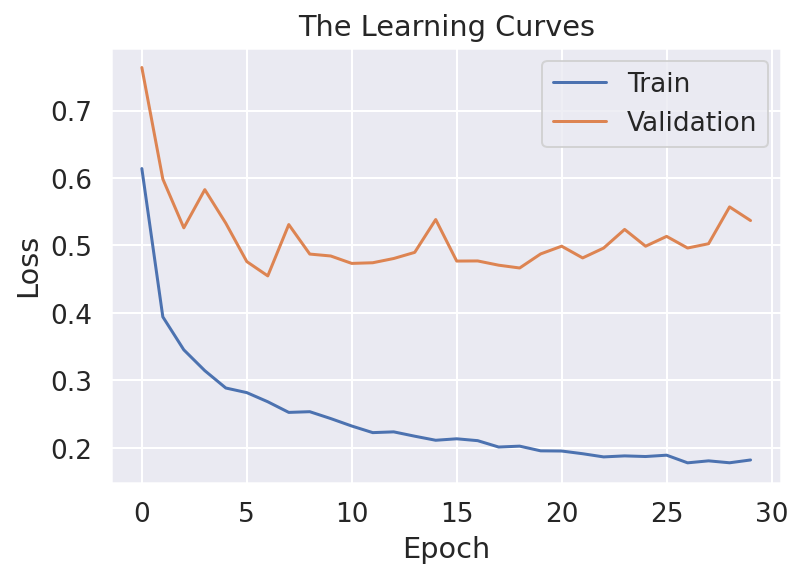

In [50]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()

plt.title('The Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

#### Matriz de Confusão

In [51]:
import pandas as pd
from torch.autograd import Variable

predicted = []
expected = []

for image, label in testset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

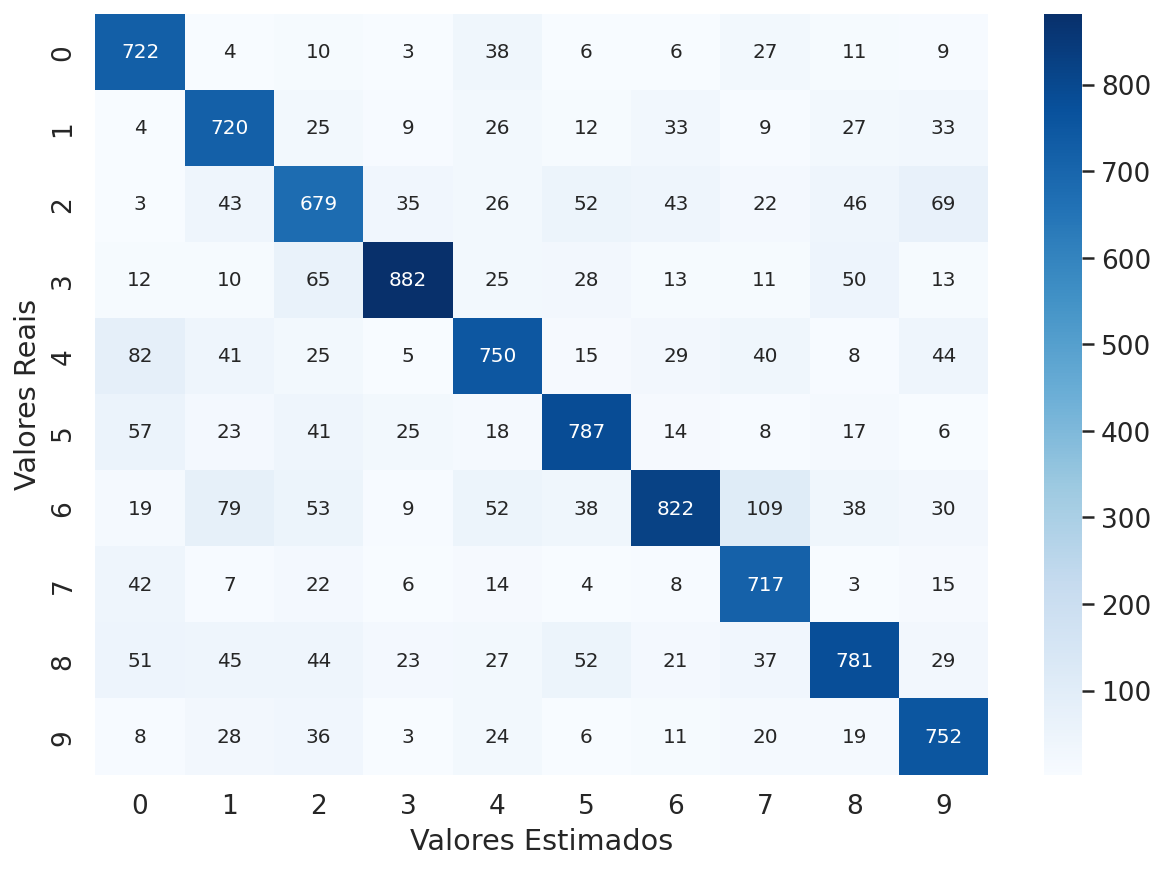

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valores Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()